# Ananlysis of private alleles and folded SFS

## Read in data and load packges

In [498]:
## set working dir
setwd("/Users/sstankow/Documents/GitHub/Littorina_reproductive_mode/012plot_privateAlleles")

## load data
data <- read.csv("012_For_R_analysis.csv", header=TRUE)

## Install packages
library(tidyverse)
library(dplyr)
library(DescTools)

head(data,5)

,entry_order,contig,cont,site,SP_1,SP_2,SP_3,SP_4,SP_5,SP_6,⋯,ARC_19,ARC_20,ARC_21,ARC_22,ARC_23,ARC_24,C_1,C_2,C_3,C_4
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1312,Contig3970,1312,483,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2
2,1381,Contig3970,1381,1863,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2
3,2461,Contig43562,2461,39372,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2
4,9073,Contig173651,9073,2208,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2
5,5681,Contig67554,5681,5511,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2


## Function for calcuting Tajimas D

In [1]:
 TajimaD <- function(sfs){
    #' sfs (site frequency spectrum): number of singletons, doubletons, ..., etc
    n <- length(sfs) + 1
    ss <- sum(sfs)
    a1 <- sum(1 / seq_len(n-1))
    a2 <- sum(1 / seq_len(n-1)^2)
    b1 <- (n + 1) / (3 * (n - 1))
    b2 <- 2 * (n^2 + n + 3)/(9 * n * (n - 1))
    c1 <- b1 - 1/a1
    c2 <- b2 - (n + 2)/(a1 * n) + a2 / a1^2
    e1 <- c1 / a1
    e2 <- c2 / (a1^2 + a2)
    Vd <- e1 * ss + e2 * ss * (ss - 1) 
    theta_pi <- sum(2 * seq_len(n-1) * (n - seq_len(n-1)) * sfs)/(n*(n-1))
    theta_w <- ss / a1
    res <- (theta_pi - theta_w) / sqrt(Vd)
    return(res)
}

## usage 
##TajimaD("vector of folded sfs")

## Egg-layers and brooders

### Calculate a bunch of new summary variables

In [500]:
## for rerence of the columns that contain data for the key groups that we want to work with

#data[85:112] ## egg-layers
#data[5:84] ## brooders
#data[109:112] ## compressa
#data[85:108] ## arcana
#data[17:84] ## north
#data[5:16]  ## spain  

In [501]:
#Set up same variables for total allele count for each groups
n_egg <- 28
n_brood <- 80
n_spain <- 12
n_north <- 68

Starting with brooders and egg-layers caculate the counts of the ref and alt alleles. The values of the genotypes are as follows: <br>
Hom ref = 0 <br>
Hom alt = 2 <br>
Het = 1 <br>
Therfore, the count for the alt alelle for a locus is just is the sum of of all of the genotypes, and for the ref alelle 2n-sumAlt. The frequencies of both allele classes is just the countAlt(Ref)/2n


In [502]:
## egg-layers
data <- data %>% mutate(alt_count_egg = rowSums(.[85:112]))
data <- data %>% mutate(ref_count_egg = 2*n_egg - rowSums(.[85:112]))
data <- data %>% mutate(p_alt_egg = alt_count_egg/(2*n_egg))
data <- data %>% mutate(p_ref_egg = ref_count_egg/(2*n_egg))
## brooders 
data <- data %>% mutate(alt_count_brood = rowSums(.[5:84]))
data <- data %>% mutate(ref_count_brood = 2*n_brood - rowSums(.[5:84]))
data <- data %>% mutate(p_alt_brood = alt_count_brood/(2*n_brood))
data <- data %>% mutate(p_ref_brood = ref_count_brood/(2*n_brood))
## north 
data <- data %>% mutate(alt_count_north = rowSums(.[17:84]))
data <- data %>% mutate(ref_count_north = 2*n_north - rowSums(.[17:84]))
data <- data %>% mutate(p_alt_north = alt_count_north/(2*n_north))
data <- data %>% mutate(p_ref_north = ref_count_north/(2*n_north))
## spain
data <- data %>% mutate(alt_count_spain = rowSums(.[5:16]))
data <- data %>% mutate(ref_count_spain = 2*n_spain - rowSums(.[5:16]))
data <- data %>% mutate(p_alt_spain = alt_count_spain/(2*n_spain))
data <- data %>% mutate(p_ref_spain = ref_count_spain/(2*n_spain))

In [503]:
## for each locus we may as well just calucate the minor count for egg and brood as we will need these later
data <- data %>% rowwise() %>% mutate(minor_count_egg = min(alt_count_egg,ref_count_egg))
data <- data %>% rowwise() %>% mutate(minor_count_brood = min(alt_count_brood,ref_count_brood))
data <- data %>% rowwise() %>% mutate(minor_count_north = min(alt_count_north,ref_count_north))
data <- data %>% rowwise() %>% mutate(minor_count_spain = min(alt_count_spain,ref_count_spain))

## Identifying private alleles

Now that we have the counts of alleles for the brooders and egglayers, we can identify aleles that are private to one of the groups (either egg-layers or brooders). 

In [504]:
data <- data %>% mutate(priv_in = case_when(
                           p_alt_egg ==1 & p_alt_brood==0 ~ 'fixed',
                           p_alt_egg ==0 & p_alt_brood==1 ~ 'fixed',
                           p_alt_egg > 0 & p_ref_egg > 0 & p_alt_brood > 0 & p_ref_brood > 0 ~ 'shared',
                           p_alt_egg == 0 & p_alt_brood > 0 & p_alt_brood < 1 ~ 'brood',
                           p_ref_egg == 0 & p_ref_brood > 0 & p_ref_brood < 1~ 'brood',
                           p_alt_brood == 0 & p_alt_egg > 0 & p_alt_egg < 1 ~ 'egg',
                           p_ref_brood == 0 & p_ref_egg > 0 & p_alt_egg < 1 ~ 'egg'))


And here are the counts of private alleles in egg-layers and broorders, as well as the fixed diffrences and number of loci where both alleles are shared between the groups.

In [505]:
table(data$priv_in)


 brood    egg  fixed shared 
  3734   4715    269    761 

### Obtianing the foldded sfs for the egg layers and brooders

In [506]:
## So here we are just computing a histogram of the minor allele counts for the group exlucing the monomorphic sites
egg.hist.info <- hist(data$minor_count_egg[data$minor_count_egg > 0],  breaks = seq(0, n_egg, length.out = n_egg+1), plot=FALSE)
eggSFS <- as.vector(egg.hist.info$counts)
eggTotal <- sum(eggSFS)

propEgg <- c()
seq <- c(1:n_egg)
for (i in seq){
   temp <-eggSFS[i]/eggTotal
propEgg[i]<-temp
}
## tajimas D
tajEgg <- TajimaD(eggSFS)
tajEgg


[1] -0.2410883

In [507]:
## same for brooders
brood.hist.info <- hist(data$minor_count_brood[data$minor_count_brood > 0],  breaks = seq(0, n_brood, length.out = n_brood+1),plot=FALSE)
broodSFS <- as.vector(brood.hist.info$counts)
broodTotal <- sum(broodSFS)

propBrood <- c()
seq <- c(1:n_brood)
for (i in seq){
   temp <-broodSFS[i]/broodTotal
propBrood[i]<-temp
}

tajBrood <- TajimaD(broodSFS)
tajBrood


[1] -1.892579

In [508]:
## now north
north.hist.info <- hist(data$minor_count_north[data$minor_count_north > 0],  breaks = seq(0, n_north, length.out = n_north+1),,plot=FALSE)
northSFS <- as.vector(north.hist.info$counts)
northTotal <- sum(northSFS)

propNorth <- c()
seq <- c(1:n_north)
for (i in seq){
   temp <-northSFS[i]/northTotal
propNorth[i]<-temp
}

tajNorth <- TajimaD(northSFS)
tajNorth


[1] -1.747032

In [509]:
## and spain 
spain.hist.info <- hist(data$minor_count_spain[data$minor_count_spain > 0],  breaks = seq(0, n_spain, length.out = n_spain+1),,plot=FALSE)
spainSFS <- as.vector(spain.hist.info$counts)
spainTotal <- sum(spainSFS)

propSpain <- c()
seq <- c(1:n_spain)
for (i in seq){
   temp <-spainSFS[i]/spainTotal
propSpain[i]<-temp
}

tajSpain <- TajimaD(spainSFS)
tajSpain

[1] -0.5896127

In [510]:
### make a plot of all four spectra
#Open a pdf file
pdf("brood_egg_full_spectra.pdf", width = 10, height = 10) 
par(mfrow=c(2,2))
barplot(propEgg, ylim=c(0,0.5), beside = TRUE)
barplot(propBrood, ylim=c(0,0.5), beside = TRUE)
barplot(propNorth, ylim=c(0,0.5), beside = TRUE)
barplot(propSpain, ylim=c(0,0.5), beside = TRUE)
#Close the pdf file
dev.off() 

pdf 
  2

## Jackknifing estimates of Tajima's D

We will now obtain estimates of the variance in Tajima's D by Jackknifing for each group. This involves calculating Tajima's  

Time difference of 1.542032 secs

[1] 0.1047225

[1] -0.2372097

[1] 0.1020247

[1] -0.03724121

[1] -0.4371782

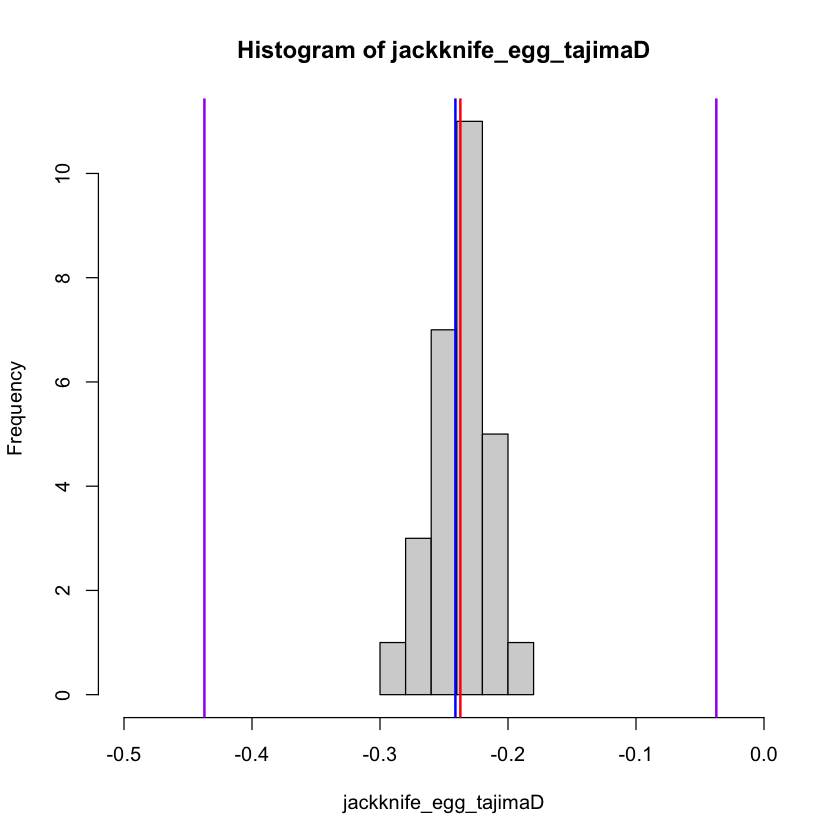

In [659]:
### egg-layers first
start.time <- Sys.time()
### start with empty vectors to catch variables
jackknife_egg_tajimaD <- c()
### set number of terms

for(i in 1:n_egg){
### grab the egglayers 
egg_layers <- data[85:112]
egg_down_sample <-as.data.frame(egg_layers[-i])
    
### calculate allele counts and proportions
egg_down_sample <- egg_down_sample %>% mutate(alt_count = rowSums(.[1:27]))
egg_down_sample <- egg_down_sample %>% mutate(ref_count = (54) - rowSums(.[1:27]))
egg_down_sample <- egg_down_sample %>% mutate(p_alt = alt_count/(54))
egg_down_sample <- egg_down_sample %>% mutate(p_ref = ref_count/(54))

## and the minor counts
egg_down_sample <- egg_down_sample %>% rowwise() %>% mutate(minor_count = min(alt_count,ref_count))

### produce folded sfs and calc Tajima's D
temp_hist <- hist(egg_down_sample$minor_count[egg_down_sample$minor_count > 0], breaks = seq(0, 27, length.out = 28),plot=FALSE)
tempSFS <- as.vector(temp_hist$counts)
temp_tajima <- TajimaD(tempSFS)
jackknife_egg_tajimaD[i] <- temp_tajima
}
### 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

mean.jack.egg <- mean(jackknife_egg_tajimaD)          ##### jacknife mean
bias <- (n_egg-1)*(mean.jack.egg-tajEgg)    ### bias
jack.SE <- sqrt(((n_egg-1)/n_egg) * sum((jackknife_egg_tajimaD-mean.jack.egg)^2)) ## SE
upper_95egg <- mean.jack.egg + jack.SE*1.96 ## upper 95
lower_95egg <- mean.jack.egg - jack.SE*1.96 ## lower 95

hist(jackknife_egg_tajimaD, breaks=5, xlim=c(-0.5,0))
abline(v=mean(jackknife_egg_tajimaD), col="red",lwd=2)
abline(v=tajEgg, col="blue",lwd=2)
abline(v=upper_95egg,col="purple",lwd=2)
abline(v=lower_95egg,col="purple",lwd=2)

bias
mean.jack.egg
jack.SE
upper_95egg
lower_95egg

Time difference of 5.023301 secs

[1] -1.888748

[1] 0.3026307

[1] 0.06053831

[1] -1.770093

[1] -2.007403

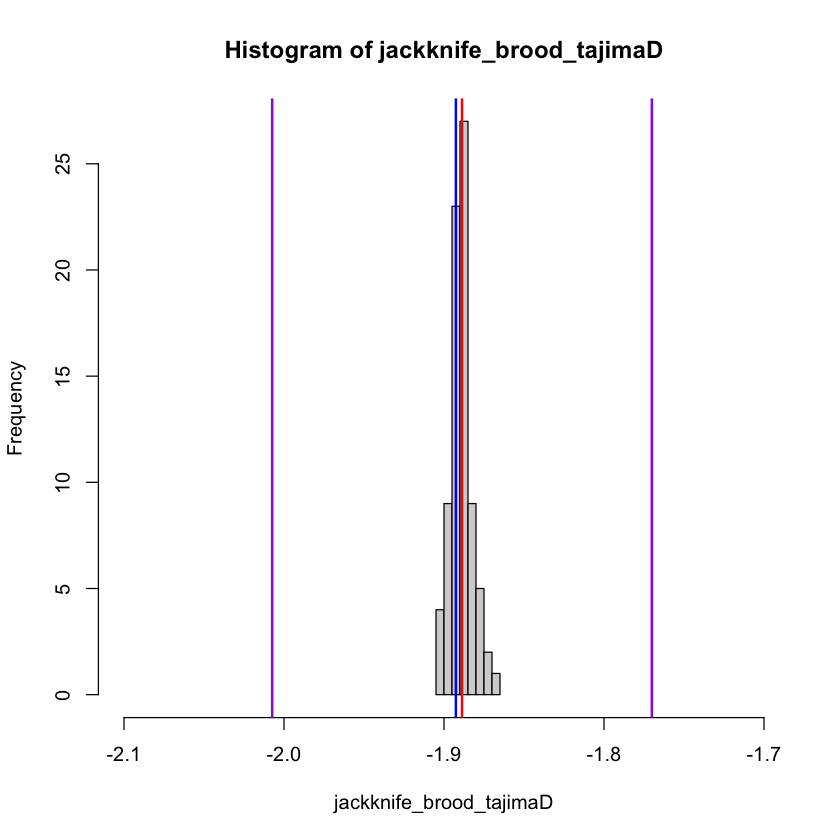

In [658]:
### brooders next
start.time <- Sys.time()
### start with empty vectors to catch variables
jackknife_brood_tajimaD <- c()

for(i in 1:n_brood){
### grab the brooders
brooders <- data[5:84]
brood_down_sample <-as.data.frame(brooders[-i])    

### calculate allele counts and proportions
brood_down_sample <- brood_down_sample  %>% mutate(alt_count = rowSums(.[1:79]))
brood_down_sample  <- brood_down_sample %>% mutate(ref_count = (158) - rowSums(.[1:79]))
brood_down_sample  <- brood_down_sample %>% mutate(p_alt = alt_count/(158))
brood_down_sample <- brood_down_sample %>% mutate(p_ref = ref_count/(158))

## and the minor counts
brood_down_sample <- brood_down_sample %>% rowwise() %>% mutate(minor_count = min(alt_count,ref_count))

### produce folded sfs and calc Tajima's D
temp_hist <- hist(brood_down_sample$minor_count[brood_down_sample$minor_count > 0], breaks = seq(0, 79, length.out = 80),plot=FALSE)
tempSFS <- as.vector(temp_hist$counts)
temp_tajima <- TajimaD(tempSFS)
jackknife_brood_tajimaD[i] <- temp_tajima
}
### 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

mean.jack.brood <- mean(jackknife_brood_tajimaD)          ##### jacknife mean
bias <- (n_brood-1)*(mean.jack.brood-tajBrood)    ### bias
jack.SE <- sqrt(((n_brood-1)/n_brood) * sum((jackknife_brood_tajimaD-mean.jack.brood)^2)) ## SE
upper_95brood <- mean.jack.brood + jack.SE*1.96 ## upper 95
lower_95brood <- mean.jack.brood - jack.SE*1.96 ## lower 95

hist(jackknife_brood_tajimaD, xlim=c(-2.10,-1.7))
abline(v=mean(jackknife_brood_tajimaD), col="red",lwd=2)
abline(v=tajBrood, col="blue",lwd=2)
abline(v=upper_95brood,col="purple",lwd=2)
abline(v=lower_95brood,col="purple",lwd=2)

mean.jack.brood
bias
jack.SE
upper_95brood
lower_95brood



Time difference of 4.044352 secs

[1] -1.741819

[1] 0.3492444

[1] 0.06626503

[1] -1.61194

[1] -1.871698

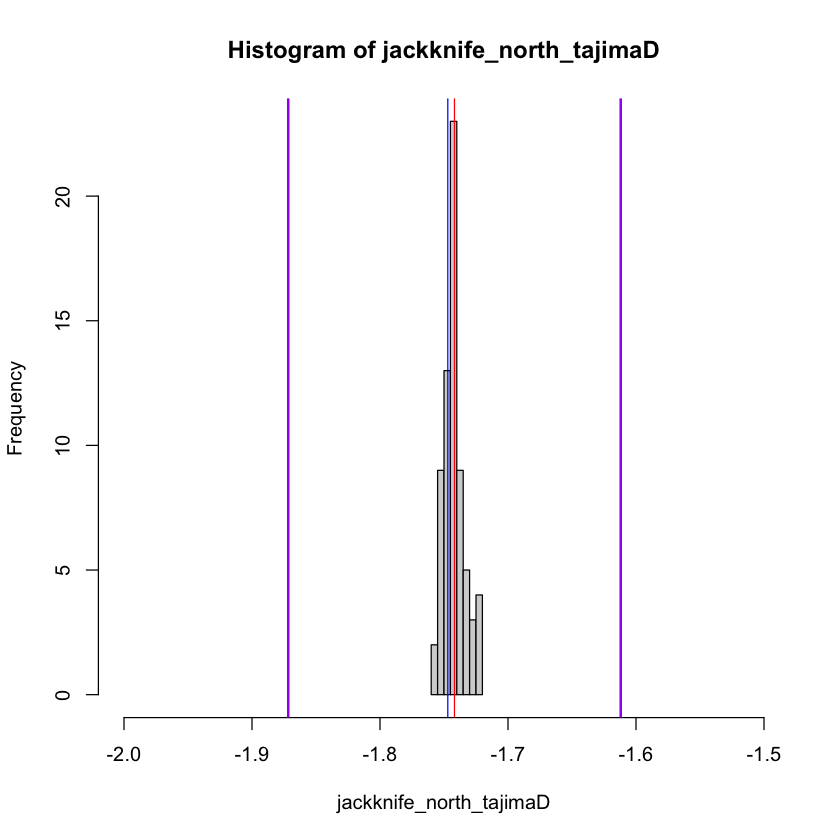

In [661]:
## north next
start.time <- Sys.time()
### start with empty vectors to catch variables
jackknife_north_tajimaD <- c()

for(i in 1:n_north){
north <- data[17:84]
north_down_sample <-as.data.frame(north[-i])  

### calculate allele counts and proportions
north_down_sample <- north_down_sample  %>% mutate(alt_count = rowSums(.[1:67]))
north_down_sample  <- north_down_sample %>% mutate(ref_count = (134) - rowSums(.[1:67]))
north_down_sample  <- north_down_sample %>% mutate(p_alt = alt_count/(134))
north_down_sample <- north_down_sample %>% mutate(p_ref = ref_count/(134))

## and the minor counts
north_down_sample <- north_down_sample %>% rowwise() %>% mutate(minor_count = min(alt_count,ref_count))

### produce folded sfs and calc Tajima's D
temp_hist <- hist(north_down_sample$minor_count[north_down_sample$minor_count > 0], breaks = seq(0, 67, length.out = 68),plot=FALSE)
tempSFS <- as.vector(temp_hist$counts)
temp_tajima <- TajimaD(tempSFS)
jackknife_north_tajimaD[i] <- temp_tajima
}
### 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

mean.jack.north <- mean(jackknife_north_tajimaD)          ##### jacknife mean
bias <- (n_north-1)*(mean.jack.north-tajNorth)    ### bias
jack.SE <- sqrt(((n_north-1)/n_north) * sum((jackknife_north_tajimaD-mean.jack.north)^2)) ## SE
upper_95north <- mean.jack.north + jack.SE*1.96 ## upper 95
lower_95north <- mean.jack.north - jack.SE*1.96 ## lower 95

hist(jackknife_north_tajimaD, xlim=c(-2,-1.5))
abline(v=mean(jackknife_north_tajimaD), col="red")
abline(v=tajNorth, col="blue")
abline(v=upper_95north,col="purple",lwd=2)
abline(v=lower_95north,col="purple",lwd=2)

mean.jack.north
bias
jack.SE
upper_95north
lower_95north



Time difference of 0.614902 secs

[1] -0.5418206

[1] 0.5257136

[1] 0.1338538

[1] -0.2794672

[1] -0.804174

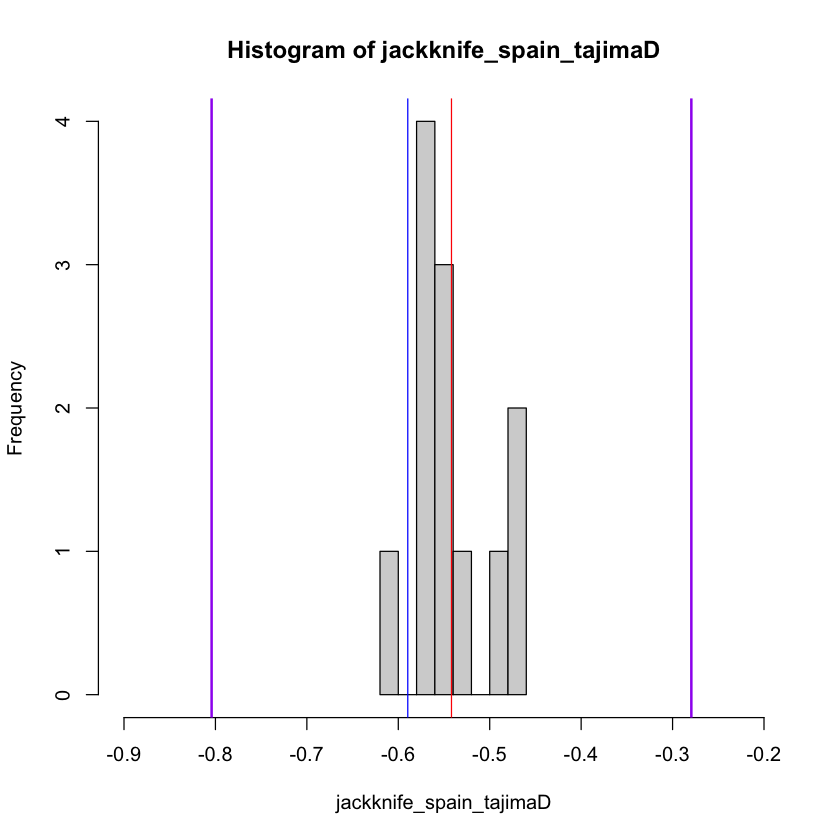

In [664]:
## spain next
start.time <- Sys.time()
### start with empty vectors to catch variables
jackknife_spain_tajimaD <- c()

for(i in 1:n_spain){
spain <- data[5:16]

### convert to a dataframe
spain_down_sample <-as.data.frame(spain[-i])  

### calculate allele counts and proportions
spain_down_sample <- spain_down_sample  %>% mutate(alt_count = rowSums(.[1:11]))
spain_down_sample  <- spain_down_sample %>% mutate(ref_count = (22) - rowSums(.[1:11]))
spain_down_sample  <- spain_down_sample %>% mutate(p_alt = alt_count/(22))
spain_down_sample <- spain_down_sample %>% mutate(p_ref = ref_count/(22))

## and the minor counts
spain_down_sample <- spain_down_sample %>% rowwise() %>% mutate(minor_count = min(alt_count,ref_count))

### produce folded sfs and calc Tajima's D
temp_hist <- hist(spain_down_sample$minor_count[spain_down_sample$minor_count > 0], breaks = seq(0, 11, length.out = 12),plot=FALSE)
tempSFS <- as.vector(temp_hist$counts)
temp_tajima <- TajimaD(tempSFS)
jackknife_spain_tajimaD[i] <- temp_tajima
}
### 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

mean.jack.spain <- mean(jackknife_spain_tajimaD)          ##### jacknife mean
bias <- (n_spain-1)*(mean.jack.spain-tajSpain)    ### bias
jack.SE <- sqrt(((n_spain-1)/n_spain) * sum((jackknife_spain_tajimaD-mean.jack.spain)^2)) ## SE
upper_95spain <- mean.jack.spain + jack.SE*1.96 ## upper 95
lower_95spain <- mean.jack.spain - jack.SE*1.96 ## lower 95

hist(jackknife_spain_tajimaD, xlim=c(-0.9,-0.2))
abline(v=mean(jackknife_spain_tajimaD), col="red")
abline(v=tajSpain, col="blue")
abline(v=upper_95spain,col="purple",lwd=2)
abline(v=lower_95spain,col="purple",lwd=2)

mean.jack.spain
bias
jack.SE
upper_95spain
lower_95spain



## Print jackknife distributions for all 4 groups

In [667]:
#pdf("Jackknifed_tajD_dists.pdf", width = 6.5, height = 6.5) 
par(mfrow=c(2,2))

hist(jackknife_egg_tajimaD, breaks=5, xlim=c(-0.5,0), border=F)
abline(v=mean(jackknife_egg_tajimaD), col="red",lwd=2)
abline(v=tajEgg, col="blue",lwd=2)
abline(v=upper_95egg,col="purple",lwd=2)
abline(v=lower_95egg,col="purple",lwd=2)

hist(jackknife_brood_tajimaD, xlim=c(-2.10,-1.7), border=F)
abline(v=mean(jackknife_brood_tajimaD), col="red",lwd=2)
abline(v=tajBrood, col="blue",lwd=2)
abline(v=upper_95brood,col="purple",lwd=2)
abline(v=lower_95brood,col="purple",lwd=2)

hist(jackknife_north_tajimaD, xlim=c(-2,-1.5), border=F)
abline(v=mean(jackknife_north_tajimaD), col="red")
abline(v=tajNorth, col="blue")
abline(v=upper_95north,col="purple",lwd=2)
abline(v=lower_95north,col="purple",lwd=2)

hist(jackknife_spain_tajimaD, xlim=c(-0.9,-0.2), border=F)
abline(v=mean(jackknife_spain_tajimaD), col="red")
abline(v=tajSpain, col="blue")
abline(v=upper_95spain,col="purple",lwd=2)
abline(v=lower_95spain,col="purple",lwd=2)


#dev.off() 

border=F

pdf 
  2

In [707]:
## tajima D with confidence intervals
pdf("tajimaD_dotsCIs.pdf", width = 10, height = 5) 
par(mfrow=c(1,1))

groups <- c(4,3,2,1)
est <- c(-0.241, -1.893, -1.747, -0.59)
jack <- c(-0.237, -1.889, -1.742, -0.542)
plot(jack,groups, xlim=c(-2.1,0.1), pch=groups, cex=2)
points(dots$est,groups)

CI1 <- c(-0.037, -1.77, -1.612, -0.279)
CI2 <- c(-0.437, -2.007, -1.872, -0.804)
points(CI1,groups)
points(CI2,groups)
dev.off()

pdf 
  2

## Estimating proportions of private alleles: adjusting for differences in sample size downsampling

Here Im just getting the code worked out for a single replcate before I put all of this into a for-loop

In [19]:
### sample 28 individuals from the northern group with replacement
sample_north <- data[,sample(5:84,28, replace=T)]

In [39]:
### sample the egg-layers
egg_layers <- data[,sample(85:112,28, replace=T)]

In [21]:
#bind the dataframes together
bound_data <- cbind(sample_north,egg_layers)
## rename the individuals so they are uniqe as this is required for the calculations underneath
colnames(bound_data) <-c(1:56)

In [22]:
##### now compute variables as above but specifying new ranges
#bound_data[1:28] brooders
#bound_data[29:56] egg-layers
## egg-layers
bound_data <- bound_data %>% mutate(alt_count_egg = rowSums(.[29:56]))
bound_data <- bound_data %>% mutate(ref_count_egg = (56) - rowSums(.[29:56]))
bound_data <- bound_data %>% mutate(p_alt_egg = alt_count_egg/(56))
bound_data <- bound_data %>% mutate(p_ref_egg = ref_count_egg/(56))
## brooders 
bound_data <- bound_data %>% mutate(alt_count_brood = rowSums(.[1:28]))
bound_data <- bound_data %>% mutate(ref_count_brood = (56) - rowSums(.[1:28]))
bound_data <- bound_data %>% mutate(p_alt_brood = alt_count_brood/(56))
bound_data <- bound_data %>% mutate(p_ref_brood = ref_count_brood/(56))
## and the minor counts
bound_data <- bound_data %>% rowwise() %>% mutate(minor_count_egg = min(alt_count_egg,ref_count_egg))
bound_data <- bound_data %>% rowwise() %>% mutate(minor_count_brood = min(alt_count_brood,ref_count_brood))


In [23]:
### now classify the alleles
bound_data <- bound_data %>% mutate(priv_in = case_when(
                           p_alt_egg ==1 & p_alt_brood==0 ~ 'fixed',
                           p_alt_egg ==0 & p_alt_brood==1 ~ 'fixed',
                           p_alt_egg > 0 & p_ref_egg > 0 & p_alt_brood > 0 & p_ref_brood > 0 ~ 'shared',
                           p_alt_egg == 0 & p_alt_brood > 0 & p_alt_brood < 1 ~ 'brood',
                           p_ref_egg == 0 & p_ref_brood > 0 & p_ref_brood < 1~ 'brood',
                           p_alt_brood == 0 & p_alt_egg > 0 & p_alt_egg < 1 ~ 'egg',
                           p_ref_brood == 0 & p_ref_egg > 0 & p_alt_egg < 1 ~ 'egg'))

In [24]:
boot_brood.hist.info <- hist(bound_data$minor_count_brood[bound_data$minor_count_brood > 0],  breaks = seq(0, 28, length.out = 29),,plot=FALSE)
boot_broodSFS <- as.vector(boot_brood.hist.info$counts)
boot_egg.hist.info <- hist(bound_data$minor_count_egg[bound_data$minor_count_egg > 0],  breaks = seq(0, 28, length.out = 29),,plot=FALSE)
boot_eggSFS <- as.vector(boot_egg.hist.info$counts)
joinedSFS <- cbind(boot_broodSFS,boot_eggSFS)
g<-as.vector(GTest(joinedSFS))



In [25]:
## calculate some summary stats
#counts <- table(bound_data$priv_in)
#pvt_brood <- counts[1]
#pvt_egg <- counts[2]
#fixed <- counts[3]
#shared <- counts[4]
#prop_pvt_brood <- pvt_brood/(pvt_brood+shared)
#prop_pvt_egg <- pvt_egg/(pvt_egg+shared)
#count_higher_egg <- pvt_egg > pvt_brood
#prop_higer_egg <- prop_pvt_egg > prop_pvt_brood

## Obtaining a distributions of private alleles thought iterative downsampling

In [594]:
## start a run clock
start.time <- Sys.time()
### start with empty vectors to catch variables
pvt_brood_temp <- c()
pvt_egg_temp <- c()
fixed_temp <- c() 
shared_temp <- c()
prop_pvt_brood_temp <- c()
prop_pvt_egg_temp <- c()
count_higher_egg_temp <- c()
prop_higer_egg_temp <- c()
Gtest_p <- c()

### set number of permutations
n_perms <- 10000
for(i in 1:n_perms){

### grab the egg-layers
egg_layers <- data[85:112]
    
### sample n brooders without replacement
set.seed(i) 
sample_brood <- data[,sample(5:84,28, replace=F)]
    
#bind the dataframes together
bound_data <- cbind(sample_brood,egg_layers)
## rename the individuals so they are uniqe as this is required for the calculations underneath
colnames(bound_data) <-c(1:56)
    
##### now compute variables as above but specifying new ranges
#bound_data[1:28] brooders
#bound_data[29:56] egg-layers
## egg-layers
bound_data <- bound_data %>% mutate(alt_count_egg = rowSums(.[29:56]))
bound_data <- bound_data %>% mutate(ref_count_egg = (56) - rowSums(.[29:56]))
bound_data <- bound_data %>% mutate(p_alt_egg = alt_count_egg/(56))
bound_data <- bound_data %>% mutate(p_ref_egg = ref_count_egg/(56))
## brooders 
bound_data <- bound_data %>% mutate(alt_count_brood = rowSums(.[1:28]))
bound_data <- bound_data %>% mutate(ref_count_brood = (56) - rowSums(.[1:28]))
bound_data <- bound_data %>% mutate(p_alt_brood = alt_count_brood/(56))
bound_data <- bound_data %>% mutate(p_ref_brood = ref_count_brood/(56))

    ## and the minor counts
bound_data <- bound_data %>% rowwise() %>% mutate(minor_count_egg = min(alt_count_egg,ref_count_egg))
bound_data <- bound_data %>% rowwise() %>% mutate(minor_count_brood = min(alt_count_brood,ref_count_brood))

### now classify the alleles
bound_data <- bound_data %>% mutate(priv_in = case_when(
    p_alt_egg ==1 & p_alt_brood==0 ~ 'fixed',
    p_alt_egg ==0 & p_alt_brood==1 ~ 'fixed',
    p_alt_egg > 0 & p_ref_egg > 0 & p_alt_brood > 0 & p_ref_brood > 0 ~ 'shared',
    p_alt_egg == 0 & p_alt_brood > 0 & p_alt_brood < 1 ~ 'brood',
    p_ref_egg == 0 & p_ref_brood > 0 & p_ref_brood < 1~ 'brood',
    p_alt_brood == 0 & p_alt_egg > 0 & p_alt_egg < 1 ~ 'egg',
    p_ref_brood == 0 & p_ref_egg > 0 & p_alt_egg < 1 ~ 'egg'))

## tabulate results
counts <- table(bound_data$priv_in)    
    
## calculate some summary stats; could take this of the loop and calculate from the dataframe later
pvt_brood <- counts[1]
pvt_egg <- counts[2]
fixed <- counts[3]
shared <- counts[4]
prop_pvt_brood <- pvt_brood/(pvt_brood+shared)
prop_pvt_egg <- pvt_egg/(pvt_egg+shared)

pvt_brood_temp[i] <- pvt_brood 
pvt_egg_temp[i] <- pvt_egg 
fixed_temp[i] <- fixed 
shared_temp[i] <- shared
prop_pvt_brood_temp[i] <- prop_pvt_brood
prop_pvt_egg_temp[i] <- prop_pvt_egg

### compare the bootstrap sfs with a g-test
boot_brood.hist.info <- hist(bound_data$minor_count_brood[bound_data$minor_count_brood > 0],  breaks = seq(0, 28, length.out = 29),plot=FALSE)
boot_broodSFS <- as.vector(boot_brood.hist.info$counts)
boot_egg.hist.info <- hist(bound_data$minor_count_egg[bound_data$minor_count_egg > 0],  breaks = seq(0, 28, length.out = 29),plot=FALSE)
boot_eggSFS <- as.vector(boot_egg.hist.info$counts)
joinedSFS <- cbind(boot_broodSFS,boot_eggSFS)
g <- GTest(joinedSFS)
Gtest_p[i]<-as.character(g[3]<0.05)
}
### 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 8.01353 hours

In [595]:
bootstrap_out <- as.data.frame(cbind(pvt_brood_temp,pvt_egg_temp,fixed_temp,shared_temp,prop_pvt_brood_temp,prop_pvt_egg_temp))
bootstrap_out <- bootstrap_out %>% mutate(diff_p_priv_EggBrood = prop_pvt_egg_temp - prop_pvt_brood_temp)
bootstrap_out <- cbind(bootstrap_out,Gtest_p)
#write.csv(bootstrap_out, "bootstrap_out_broodEgg.csv")

In [596]:
### summarise the results of the G-tests
table(bootstrap_out$Gtest_p)


 TRUE 
10000 

So here all 1000 pairs of bootrapped spectra are singnificantly different according to G-tests

In [717]:
### calulcate means for the replicates
head(bootstrap_out)
mean(bootstrap_out$pvt_brood_temp)
mean(bootstrap_out$pvt_egg_temp)
mean(bootstrap_out$prop_pvt_brood_temp)
mean(bootstrap_out$prop_pvt_egg_temp)
mean(bootstrap_out$diff_p_priv_EggBrood)


,pvt_brood_temp,pvt_egg_temp,fixed_temp,shared_temp,prop_pvt_brood_temp,prop_pvt_egg_temp,diff_p_priv_EggBrood,Gtest_p
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2133,4951,313,525,0.8024831,0.9041271,0.10164403,TRUE
2,2025,4972,314,504,0.8007117,0.9079620,0.10725027,TRUE
3,2011,4949,315,527,0.7923562,0.9037619,0.11140568,TRUE
4,2085,4926,306,550,0.7912713,0.8995617,0.10829038,TRUE
5,1918,4998,320,478,0.8005008,0.9127100,0.11220917,TRUE
6,2291,4919,307,557,0.8044242,0.8982834,0.09385926,TRUE


[1] 2063.299

[1] 4964.745

[1] 0.801416

[1] 0.9066371

[1] 0.1052211

## Spain vs north

Now we need to do the same for north vs spain. There are 12 Spain individuals, so we can just use the code above, sampling only 12 north, and replacing the arcana group with the spain group and adjust the sample size in the calculations. Also, we can strict this analysis only to SNPs that are private to brooders that we identified in the previous analysis (subset by pvt_in)

In [597]:
start.time <- Sys.time()
## redfine the datframe
S_data <- subset(data, priv_in == "brood")

### start with empty vectors to catch variables
S_pvt_north_temp <- c()
S_pvt_spain_temp <- c()
S_shared_temp <- c()
S_prop_pvt_north_temp <- c()
S_prop_pvt_spain_temp <- c()
S_count_higher_spain_temp <- c()
S_prop_higer_spain_temp <- c()
S_Gtest_p <- c()

### set number of permutations
n_perms <- 10000
for(i in 1:n_perms){

## grab the spanish samples
spain <- S_data[5:16]
    
### sample 12 individuals from the northern group with replacement
sample_north <- S_data[,sample(17:84,12, replace=F)]

### bind the data frames
S_bound_data <- cbind(sample_north,spain)
colnames(S_bound_data) <-c(1:24)

## spain
S_bound_data <- S_bound_data %>% mutate(alt_count_spain = rowSums(.[13:24]))
S_bound_data <- S_bound_data %>% mutate(ref_count_spain = (24) - rowSums(.[13:24]))
S_bound_data <- S_bound_data %>% mutate(p_alt_spain = alt_count_spain/(24))
S_bound_data <- S_bound_data %>% mutate(p_ref_spain = ref_count_spain/(24))

## north
S_bound_data <- S_bound_data %>% mutate(alt_count_north = rowSums(.[1:12]))
S_bound_data <- S_bound_data %>% mutate(ref_count_north = (24) - rowSums(.[1:12]))
S_bound_data <- S_bound_data %>% mutate(p_alt_north = alt_count_north/(24))
S_bound_data <- S_bound_data %>% mutate(p_ref_north = ref_count_north/(24))

## and the minor counts
S_bound_data <- S_bound_data %>% rowwise() %>% mutate(minor_count_spain = min(alt_count_spain,ref_count_spain))
S_bound_data <- S_bound_data %>% rowwise() %>% mutate(minor_count_north = min(alt_count_north,ref_count_north))

### now classify the alleles  ### removed teh fixed categories because this is very stochasitc and ruins the indexing
S_bound_data <- S_bound_data %>% mutate(priv_in = case_when(
    p_alt_spain > 0 & p_ref_spain > 0 & p_alt_north > 0 & p_ref_north > 0 ~ 'shared',
    p_alt_spain == 0 & p_alt_north > 0 & p_alt_north < 1 ~ 'north',
    p_ref_spain == 0 & p_ref_north > 0 & p_ref_north < 1~ 'north',
    p_alt_north == 0 & p_alt_spain > 0 & p_alt_spain < 1 ~ 'spain',
    p_ref_north == 0 & p_ref_spain > 0 & p_alt_spain < 1 ~ 'spain'))

## tabulate results
S_counts <- table(S_bound_data$priv_in)

## calculate some summary stats; could Take this out of the loop and calculate from the dataframe later
pvt_spain <- S_counts[3]
pvt_north <- S_counts[1]
shared <- S_counts[2]
prop_pvt_north <- pvt_north/(pvt_north+shared)
prop_pvt_spain <- pvt_spain/(pvt_spain+shared)
count_higher_spain <- pvt_spain > pvt_north
prop_higer_spain <- prop_pvt_spain > prop_pvt_north

## Save these to variables
S_pvt_north_temp[i] <- pvt_north
S_pvt_spain_temp[i] <- pvt_spain 
S_shared_temp[i] <- shared
S_prop_pvt_north_temp[i] <- prop_pvt_north
S_prop_pvt_spain_temp[i] <- prop_pvt_spain
S_count_higher_spain_temp[i] <- count_higher_spain
S_prop_higer_spain_temp[i] <- prop_higer_spain
    
### compare the bootstrap sfs with a g-test
boot_spain.hist.info <- hist(S_bound_data$minor_count_spain[S_bound_data$minor_count_spain > 0],  breaks = seq(0, 12, length.out = 13),plot=FALSE)
boot_spainSFS <- as.vector(boot_spain.hist.info$counts)
boot_north.hist.info <- hist(S_bound_data$minor_count_north[S_bound_data$minor_count_north > 0],  breaks = seq(0, 12, length.out = 13),plot=FALSE)
boot_northSFS <- as.vector(boot_north.hist.info$counts)
joinedSFS <- cbind(boot_spainSFS,boot_northSFS)
g <- GTest(joinedSFS)
S_Gtest_p [i]<-as.character(g[3]<0.05)
}
### 
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.691754 hours

In [598]:
## print the file and save as a csv
S_bootstrap_out <- as.data.frame(cbind(S_pvt_north_temp,S_pvt_spain_temp,S_shared_temp,S_prop_pvt_north_temp,S_prop_pvt_spain_temp,S_count_higher_spain_temp,S_prop_higer_spain_temp))
S_bootstrap_out <- S_bootstrap_out %>% mutate(diff_p_priv_SpainNorth = S_prop_pvt_spain_temp - S_prop_pvt_north_temp)
S_bootstrap_out <- cbind(S_bootstrap_out,S_Gtest_p)
write.csv(S_bootstrap_out, "bootstrap_out_SpainNorthAllVarSItes_pvtSPAINNORTHonly.csv")



In [599]:
### summarise the results of the G-tests
table(S_bootstrap_out$S_Gtest_p)



FALSE  TRUE 
    4  9996 

So here, all 1000 boostrapped spectra are significantly different from one another according to the g-test

## Make figures of private alleles in spain and north

In [665]:
############# make pdf plots Pgroup1 - Pgroup2
#Open a pdf file
### first plots
pdf("private_alleles_Jackknife_northSpainOnly.pdf", width = 12, height = 6.5) 

par(mfrow=c(2,3))
### one
hist(bootstrap_out$pvt_egg_temp, xlim=c(0,6000), col="gray",border=F, main="", breaks = seq(0, 6000, length.out = 1000))
abline(v=(mean(bootstrap_out$pvt_egg_temp)), col="red")
hist(bootstrap_out$pvt_brood_temp, xlim=c(0,6000), col="orange",add=T,border=F, main="", breaks = seq(0, 6000, length.out = 1000))
abline(v=(mean(bootstrap_out$pvt_brood_temp)), col="red")

### two 
hist(bootstrap_out$prop_pvt_egg_temp, xlim=c(0,1), col="red",border=F, main="", breaks = seq(0, 1, length.out = 1000))
abline(v=(mean(bootstrap_out$prop_pvt_egg_temp)), col="red")
hist(bootstrap_out$prop_pvt_brood_temp, xlim=c(0,1), col="blue",add=T,border=F, main="", breaks =seq(0, 1, length.out = 1000))
abline(v=(mean(bootstrap_out$prop_pvt_brood_temp)), col="red")

### three
hist(bootstrap_out$diff_p_priv_EggBrood, xlim=c(-0.2,0.2), col="purple", border=F, main="", breaks = seq(-0.2, 0.2, length.out = 1000))
abline(v=0)
abline(v=(mean(bootstrap_out$diff_p_priv_EggBrood)),col="red")

### four
hist(S_bootstrap_out$S_pvt_spain_temp, xlim=c(0,1500), col="green", border=F, main="", breaks = seq(0, 1500, length.out = 1000))
abline(v=(mean(S_bootstrap_out$S_pvt_spain_temp)), col="red")
hist(S_bootstrap_out$S_pvt_north_temp, xlim=c(0,1500), col="gray", border=F, main="", breaks = seq(0, 1500, length.out = 1000),add=T,)
abline(v=(mean(S_bootstrap_out$S_pvt_north_temp)), col="red")

### five
hist(S_bootstrap_out$S_prop_pvt_spain_temp, xlim=c(0,1), border=F, col="gray", main="", breaks = seq(0, 1, length.out = 1000))
abline(v=(mean(S_bootstrap_out$S_prop_pvt_spain_)), col="red")
hist(S_bootstrap_out$S_prop_pvt_north_temp, xlim=c(0,11), border=F, col="blue",add=T, main="", breaks = seq(0, 1, length.out = 1000))
abline(v=(mean(S_bootstrap_out$S_prop_pvt_north_temp)), col="red")

### six
### four
hist(S_bootstrap_out$diff_p_priv_SpainNorth, xlim=c(-0.2,0.2), border=F, col="cyan", main="", breaks = seq(-0.2, 0.2, length.out = 1000))
abline(v=0)
abline(v=(mean(S_bootstrap_out$diff_p_priv_SpainNorth)), col="red")

# Close the pdf file
dev.off() 

pdf 
  2

In [716]:
## print means across all replicates
head(S_bootstrap_out)
mean(S_bootstrap_out$S_pvt_north_temp)
mean(S_bootstrap_out$S_pvt_spain_temp)
mean(S_bootstrap_out$S_prop_pvt_north_temp)
mean(S_bootstrap_out$S_prop_pvt_spain_temp)
mean(S_bootstrap_out$diff_p_priv_SpainNorth)

,S_pvt_north_temp,S_pvt_spain_temp,S_shared_temp,S_prop_pvt_north_temp,S_prop_pvt_spain_temp,S_count_higher_spain_temp,S_prop_higer_spain_temp,diff_p_priv_SpainNorth,S_Gtest_p
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,810,1062,171,0.8256881,0.8613139,1,1,0.03562580,TRUE
2,877,1068,165,0.8416507,0.8661800,1,1,0.02452938,TRUE
3,789,1078,155,0.8358051,0.8742903,1,1,0.03848526,TRUE
4,718,1063,170,0.8085586,0.8621249,1,1,0.05356634,TRUE
5,846,1069,164,0.8376238,0.8669911,1,1,0.02936732,TRUE
6,826,1056,177,0.8235294,0.8564477,1,1,0.03291828,TRUE


[1] 833.9386

[1] 1065.731

[1] 0.8325528

[1] 0.8643392

[1] 0.03178645

## making some scaled spectra for the main text

The boostrapped spectra are useful for statistical testing, but the spectra are often not a good visual approximation for actualt spectra, becuase the sampling with replacement causes singletons to become doubletons. Here, for visulisation purposes, I will produce some spectra by downsampling without replacement the larger populaltion and using the actual individuals from the smaller population, which will allow better qualitaative comparison of how the spectra differ. Another issue is that the number of loci that are polymorhic in each group varies, so, rathern than plotting the counts, we need to scale each bar as a fraction of the total number of loci that sum to one. 

This is for all variable loci, not just the alleles that are private to each group

In [219]:
######## take only alleles private to brooders or all egg layers 
data <- subset(data, priv_in == "brood" | priv_in == "egg")              ############ comment out to analyse all loci
### sample 28 individuals from the northern group with replacement
sample_north <- data[,sample(5:84,28)]
### grab the egg-layers
egg_layers <- data[85:112]
#bind the dataframes together
bound_data <- cbind(sample_north,egg_layers)
## rename the individuals so they are unique as this is required for the calculations underneath
colnames(bound_data) <-c(1:56)

##### calculate some counts of major/minor alleles
## egg-layers
bound_data <- bound_data %>% mutate(alt_count_egg = rowSums(.[29:56]))
bound_data <- bound_data %>% mutate(ref_count_egg = (56) - rowSums(.[29:56]))
bound_data <- bound_data %>% mutate(p_alt_egg = alt_count_egg/(56))
bound_data <- bound_data %>% mutate(p_ref_egg = ref_count_egg/(56))
## brooders 
bound_data <- bound_data %>% mutate(alt_count_brood = rowSums(.[1:28]))
bound_data <- bound_data %>% mutate(ref_count_brood = (56) - rowSums(.[1:28]))
bound_data <- bound_data %>% mutate(p_alt_brood = alt_count_brood/(56))
bound_data <- bound_data %>% mutate(p_ref_brood = ref_count_brood/(56))

## and the minor allele counts
bound_data <- bound_data %>% rowwise() %>% mutate(minor_count_egg = min(alt_count_egg,ref_count_egg))
bound_data <- bound_data %>% rowwise() %>% mutate(minor_count_brood = min(alt_count_brood,ref_count_brood))

## Compute the sfs for each population
boot_brood.hist.info <- hist(bound_data$minor_count_brood[bound_data$minor_count_brood > 0],  breaks = seq(0, 28, length.out = 29),plot=FALSE)
boot_broodSFS <- as.vector(boot_brood.hist.info$counts)
boot_egg.hist.info <- hist(bound_data$minor_count_egg[bound_data$minor_count_egg > 0],  breaks = seq(0, 28, length.out = 29),plot=FALSE)
boot_eggSFS <- as.vector(boot_egg.hist.info$counts)

## we need to make beight of the bars of the percentage of the number of loci rather than the counts 
totalEgg <- sum(boot_eggSFS)
prop_loci_egg <- c()
seq <- c(1:28)
for (i in seq){
   temp <-boot_eggSFS[i]/totalEgg
prop_loci_egg[i]<-temp
}

totalBrood <- sum(boot_broodSFS)
prop_loci_brood <- c()
seq <- c(1:28)
for (i in seq){
   temp <-boot_broodSFS[i]/totalBrood
prop_loci_brood[i]<-temp
}

## calculate Tajima's D for them
TajimaD(boot_eggSFS)
TajimaD(boot_broodSFS)

## Gtest of the spectra
bound.Spectra <- cbind(prop_loci_brood,prop_loci_egg)
bound.Spectra.counts <- cbind(boot_eggSFS,boot_broodSFS)
GTest(bound.Spectra.counts) 

[1] -0.3255543

[1] -1.760609


	Log likelihood ratio (G-test) test of independence without correction

data:  bound.Spectra.counts
G = 813.01, X-squared df = 27, p-value < 2.2e-16


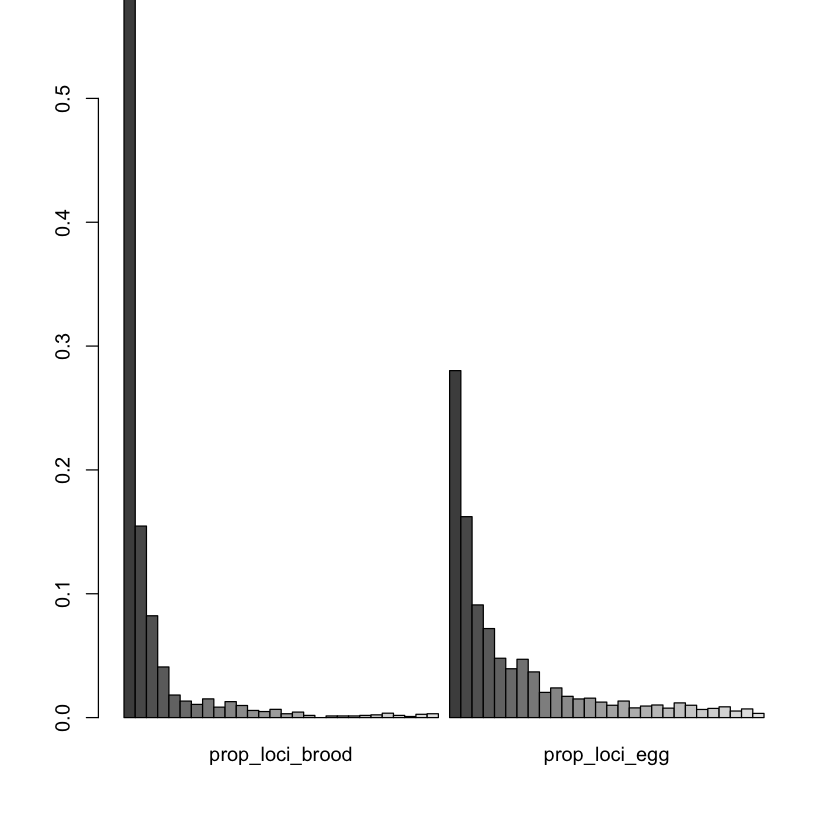

In [256]:
#pdf("boot_histograms.pdf_private_only", width = 4, height = 4) 
par(mfrow=c(1,1))
barplot(bound.Spectra, ylim=c(0,0.5), beside = TRUE)
#dev.off() 

In [472]:
### Sample 12 individuals from the northern group WITHOUT replacement
sample_north <- data[,sample(17:84,12)]

### grab the spanish samples
spain <- data[5:16]

### bind the data frames
S_bound_data <- cbind(sample_north,spain)
colnames(S_bound_data) <-c(1:24)

## spain
S_bound_data <- S_bound_data %>% mutate(alt_count_spain = rowSums(.[13:24]))
S_bound_data <- S_bound_data %>% mutate(ref_count_spain = (24) - rowSums(.[13:24]))
S_bound_data <- S_bound_data %>% mutate(p_alt_spain = alt_count_spain/(24))
S_bound_data <- S_bound_data %>% mutate(p_ref_spain = ref_count_spain/(24))

## north
S_bound_data <- S_bound_data %>% mutate(alt_count_north = rowSums(.[1:12]))
S_bound_data <- S_bound_data %>% mutate(ref_count_north = (24) - rowSums(.[1:12]))
S_bound_data <- S_bound_data %>% mutate(p_alt_north = alt_count_north/(24))
S_bound_data <- S_bound_data %>% mutate(p_ref_north = ref_count_north/(24))

## and the minor counts
S_bound_data <- S_bound_data %>% rowwise() %>% mutate(minor_count_spain = min(alt_count_spain,ref_count_spain))
S_bound_data <- S_bound_data %>% rowwise() %>% mutate(minor_count_north = min(alt_count_north,ref_count_north))

### now classify the alleles  ### removed the 'fixed' category because when not present this ruins the indexing
S_bound_data <- S_bound_data %>% mutate(priv_in = case_when(
    p_alt_spain > 0 & p_ref_spain > 0 & p_alt_north > 0 & p_ref_north > 0 ~ 'shared',
    p_alt_spain == 0 & p_alt_north > 0 & p_alt_north < 1 ~ 'north',
    p_ref_spain == 0 & p_ref_north > 0 & p_ref_north < 1~ 'north',
    p_alt_north == 0 & p_alt_spain > 0 & p_alt_spain < 1 ~ 'spain',
    p_ref_north == 0 & p_ref_spain > 0 & p_alt_spain < 1 ~ 'spain'))

## Compute the sfs for each population
## uncommment line below to analyse all polymorphic loci within groups
boot_spain.hist.info <- hist(S_bound_data$minor_count_spain[S_bound_data$minor_count_spain > 0],  breaks = seq(0, 12, length.out = 13),plot=FALSE)
## uncommment line below to analyse only alleles that are private in to group
#boot_spain.hist.info <- hist(S_bound_data$minor_count_spain[S_bound_data$minor_count_spain > 0 & S_bound_data$priv_in=='spain'],  breaks = seq(0, 12, length.out = 13),plot=FALSE)
boot_spainSFS <- as.vector(boot_spain.hist.info$counts)
## uncommment line below to analyse all polymorphic loci within groups
boot_north.hist.info <- hist(S_bound_data$minor_count_north[S_bound_data$minor_count_north > 0],  breaks = seq(0, 12, length.out = 13),plot=FALSE)
## uncommment line below to analyse only alleles that are private in to group
#boot_north.hist.info <- hist(S_bound_data$minor_count_north[S_bound_data$minor_count_north > 0 & S_bound_data$priv_in=='north'],  breaks = seq(0, 12, length.out = 13),plot=FALSE)
boot_northSFS <- as.vector(boot_north.hist.info$counts)

## we need to make beight of the bars of the percentage of the number of loci rather than the counts 
totalspain <- sum(boot_spainSFS)
prop_loci_spain <- c()
seq <- c(1:12)
for (i in seq){
   temp <-boot_spainSFS[i]/totalspain
prop_loci_spain[i]<-temp
}

totalnorth <- sum(boot_northSFS)
prop_loci_north <- c()
seq <- c(1:12)
for (i in seq){
   temp <-boot_northSFS[i]/totalnorth
prop_loci_north[i]<-temp
}

## calculate Tajima's D for them
TajimaD(boot_spainSFS)
TajimaD(boot_northSFS)

## Gtest of the spectra
bound.Spectra <- cbind(prop_loci_spain,prop_loci_north)
bound.Spectra.counts <- cbind(boot_spainSFS,boot_northSFS)
GTest(bound.Spectra.counts) 

[1] -0.5896127

[1] -1.130886


	Log likelihood ratio (G-test) test of independence without correction

data:  bound.Spectra.counts
G = 122.22, X-squared df = 11, p-value < 2.2e-16


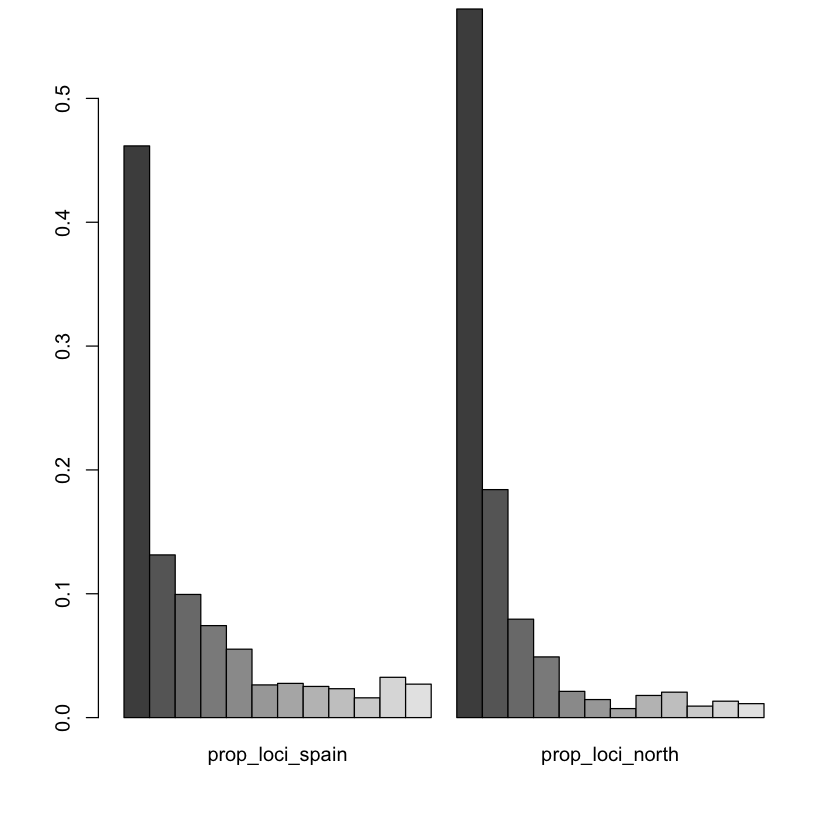

In [708]:
#pdf("downsampled_histograms_spainNorth_allLoci.pdf", width = 4, height = 4) 
par(mfrow=c(1,1))
barplot(bound.Spectra, ylim=c(0,0.5), beside = TRUE)
#dev.off() 

In [461]:
sum(prop_loci_north)

[1] 1

## Genome-wide SFS

In [68]:
sfs_folded_brooders <- c(4566926, 2007056, 1234187,  880260,  663499,  534727,  444250,  373074,  316044, 275880,  242370,  212232,  187422,  167411,  151314,  137693,  125927,  116394,  106678, 100001,   91609,   85951,   80708,   76257,   71507,   67415,   64468,   61230,   59195, 55261,   52643,   51158,   48436,   46995,   45751,   43591,   42445,   40517,   38970, 38532,   37506,   36191,   35175,   33957,   33141,   32571,   31768,   31565,   30485, 29524,   29449,   28915,   28043,   27787,   27237,   26770,   26355,   25900,   25647,   25337,   25111,   24662,   24734,   24689,   24498,   24369,   24071,   23935,   23709, 23960,   23544,   23077,   23686,   23178,   23308,   23328,   23921,   23646,  24461, 12933)
sfs_folded_egglayers <- c(2856588, 1357510,  809996,  579725,  436923,  362702,  321576,  257678,  204031, 176815,  153589,  137330, 124974,  114072,  105734,   99703,   92188,  86228, 77735,   75187,   72985,   70686,   70205,   71246,   68526,   70100,   37234) 
arc <- c(756814, 357520, 219050, 159948, 124351, 103675,  87015,  75489,  64953,  56872, 50616, 46775,  42488,  39779,  35973,  34965,  32590,  31936,  31082,  30936,  15879)
north <- c(986433, 451236, 272416, 187280, 138844, 108806,  87230,  72504,  61065,  53806,  48038,  43178, 39382, 36462,  33918,  32677,  31477,  29847,  29796, 29597,  15063)
spain <- c(745474, 360294, 223519, 159547, 122630, 103056,  88604,  79592,  73134, 70199,  69336,  34374)
comp <- c(577085, 289775, 198750, 93467)

In [70]:
### tajima D for these
TajimaD(sfs_folded_brooders)
TajimaD(sfs_folded_egglayers)

print("")

TajimaD(arc)
TajimaD(north)
TajimaD(spain)
TajimaD(comp)

[1] -0.9878535

[1] -0.4669385

[1] ""


[1] -0.2322133

[1] -0.5000185

[1] -0.120693

[1] 0.06849827

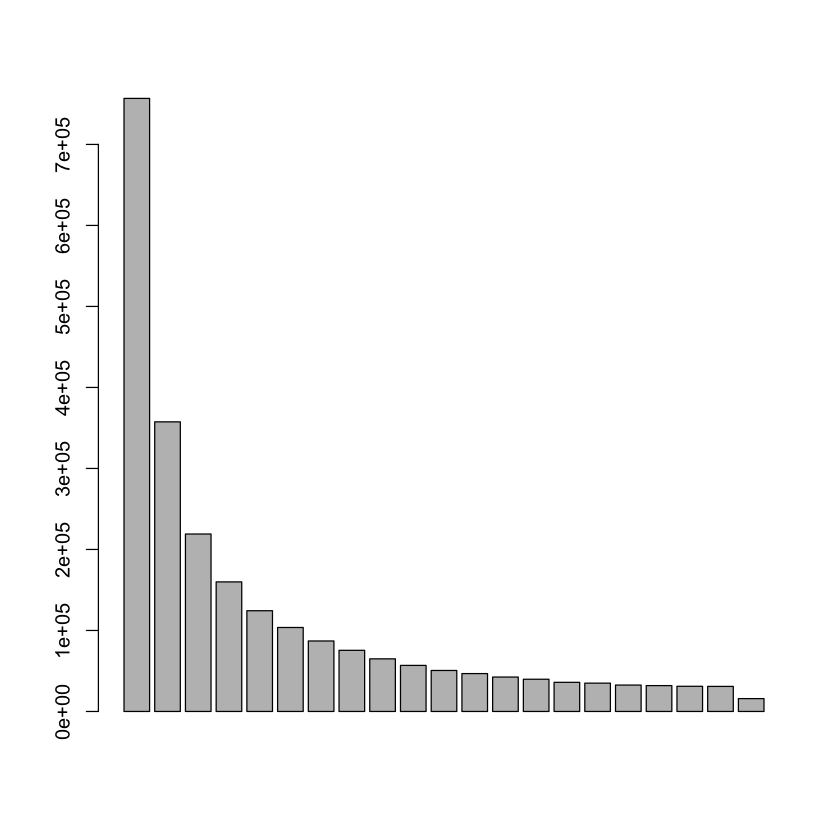

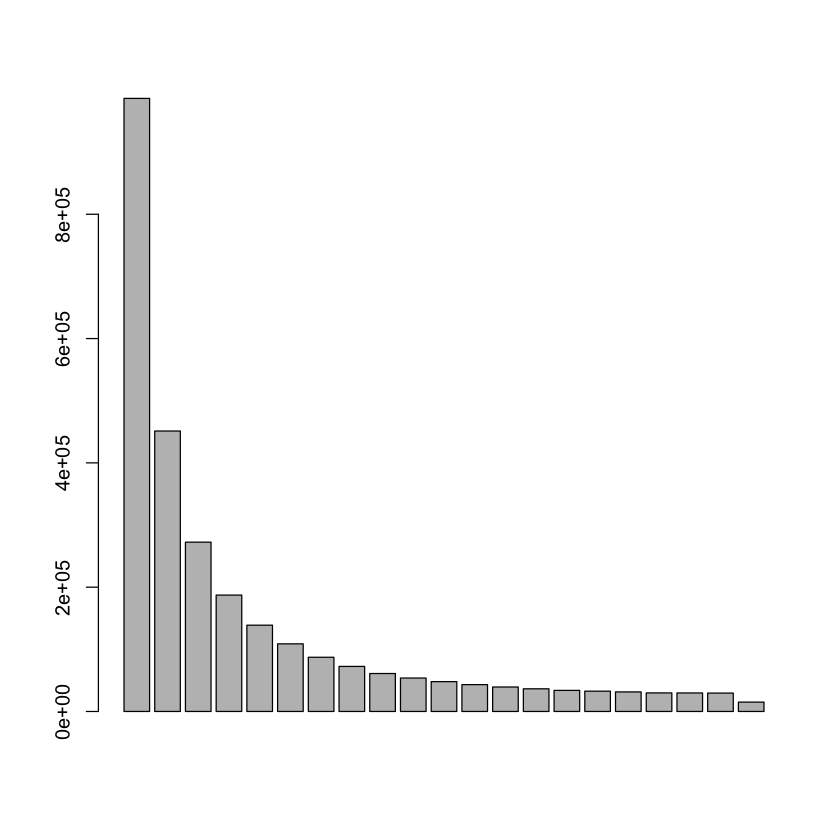

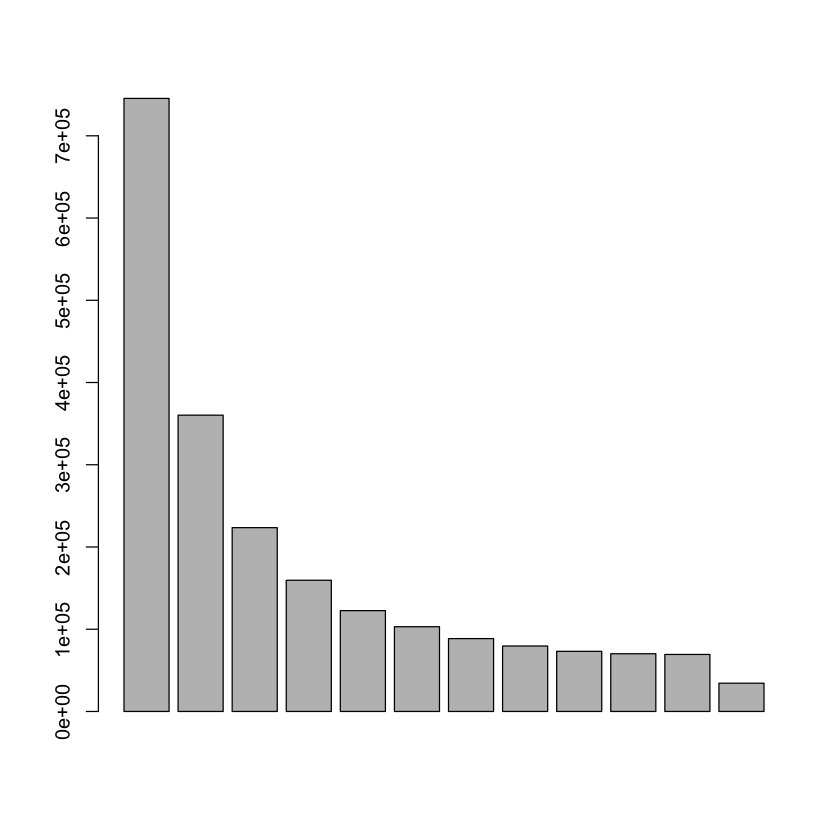

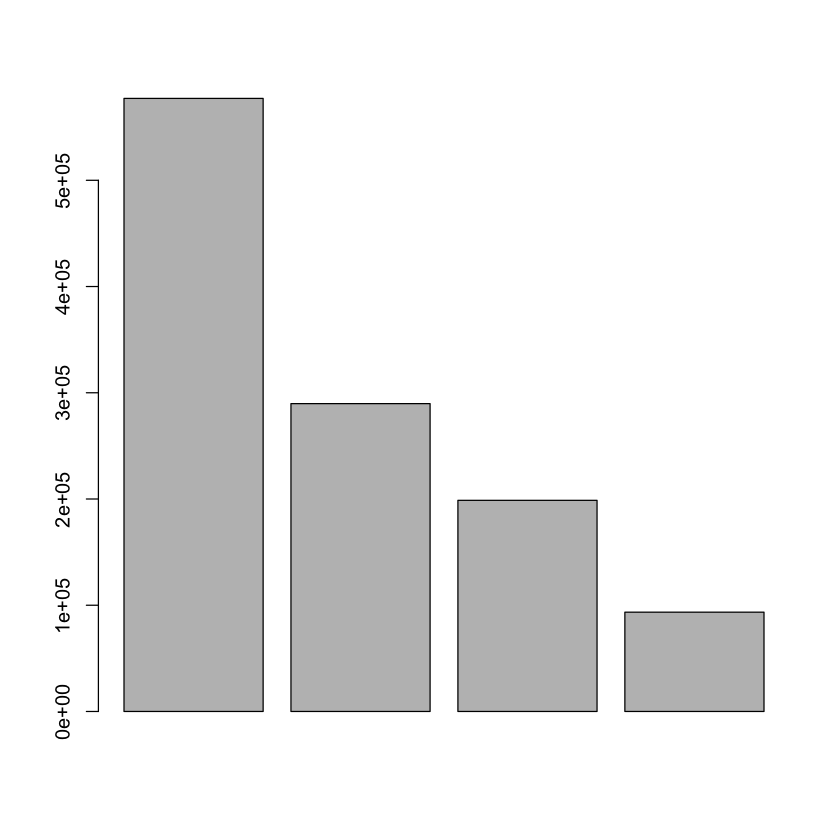

In [75]:
barplot(arc)
barplot(north)
barplot(spain)
barplot(comp)